In [ ]:
# Importar as bibliotecas necessárias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, f1_score, accuracy_score, recall_score, precision_score, plot_roc_curve
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import ADASYN
from collections import Counter
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

In [65]:
# Abrir as tabelas .csv como dataframes de trabalho
gg_train = pd.read_csv('../CSVs/games_train.csv')
gg_test = pd.read_csv('../CSVs/games_test.csv')

### Vamos excluir as colunas 'object' que não serão utilizadas.

In [31]:
# Agora vamos criar um dataset de trabalho para podermos testar os modelos.
# E já vamos tirar a coluna de target para ser a base do train_test_split.
X = gg_train.drop(columns=['churn', 
                           'creation_datetime', 
                           'last_login', 
                           'last_interaction', 
                           'inatividade', 
                           'tempo_uso'])

In [66]:
# Vamos fazer o mesmo com o dataframe de teste desconhecido.
gg_test = gg_test.drop(columns=['creation_datetime', 
                                'last_login', 
                                'last_interaction', 
                                'inatividade', 
                                'tempo_uso'])

In [67]:
# Vamos definir o user_id como index nos dois dataframes.
X.set_index('user_id', inplace=True)
gg_test.set_index('user_id', inplace=True)

In [34]:
# X.drop(columns=['profile_pic_id', 
#                 'avatar', 
#                 'ip_country_code', 
#                 'psn_id', 
#                 'xboxlive_id', 
#                 'nintendo_id', 
#                 'gamecenter_id', 
#                 'googleplay_id', 
#                 'battlenet_id', 
#                 'uplay_id', 
#                 'origin_id', 
#                 'youtube_id', 
#                 'twitch_id'], inplace=True)

In [35]:
# gg_test.drop(columns=['profile_pic_id', 
#                       'avatar', 
#                       'ip_country_code', 
#                       'psn_id', 
#                       'xboxlive_id', 
#                       'nintendo_id', 
#                       'gamecenter_id', 
#                       'googleplay_id', 
#                       'battlenet_id', 
#                       'uplay_id', 
#                       'origin_id', 
#                       'youtube_id', 
#                       'twitch_id'], inplace=True)

In [68]:
# Vamos preencher os valores nulos do dataset.
X['lat'].fillna(method='ffill', inplace=True)
X['lng'].fillna(method='ffill', inplace=True)
gg_test['lat'].fillna(method='ffill', inplace=True)
gg_test['lng'].fillna(method='ffill', inplace=True)

In [38]:
y = gg_train['churn']

### Vamos verificar o balanceamento das classes.

Class 0: 66
Class 1: 14018
Proportion: 0.0047 :1


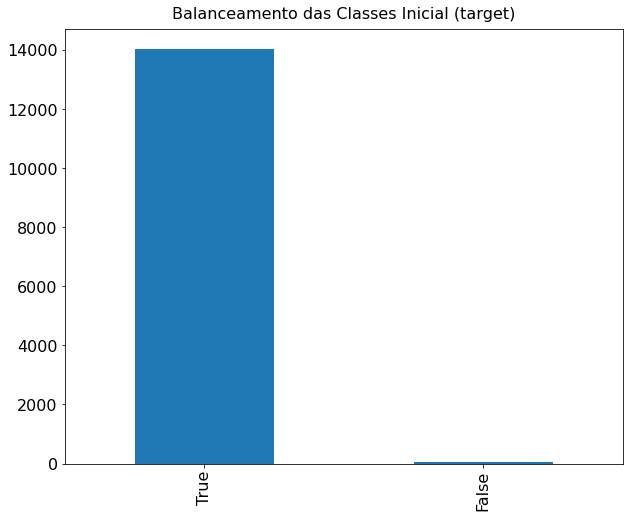

In [39]:
target_count = gg_train.churn.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 4), ':1')

target_count.plot(figsize=(10, 8), kind='bar', fontsize=16);
plt.title(label='Balanceamento das Classes Inicial (target)', fontsize=16, pad=10)
plt.savefig('../Imagens/bal_classes_init')

### Vamos tentar melhorar o balanceamento das classes usando o ADASYN

In [46]:
X.drop(51076, inplace=True)

In [47]:
y.drop(0, inplace=True)

In [60]:
print("Divisão das Classes original %s" % Counter(y))

adasyn = ADASYN(sampling_strategy=0.2, random_state=18)
X_ada, y_ada = adasyn.fit_resample(X, y)

print('Divisão das Classes ajustada %s' % Counter(y_ada))

Divisão das Classes original Counter({True: 14017, False: 66})
Divisão das Classes ajustada Counter({True: 14017, False: 2806})


Class 0: 2806
Class 1: 14017
Proportion: 0.2002 :1


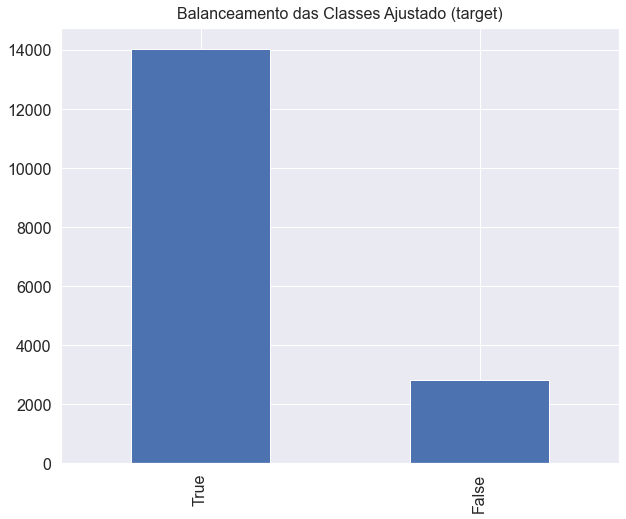

In [61]:
# Vamos verificar o balanceamento agora.
gg_ada = pd.concat([X_ada, y_ada], axis=1)
target_count = gg_ada.churn.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 4), ':1')

target_count.plot(figsize=(10, 8), kind='bar', fontsize=16);
plt.title(label='Balanceamento das Classes Ajustado (target)', fontsize=16, pad=10)
plt.savefig('../Imagens/bal_classes_adj')

### Vamos verificar se as features que restaram são todas relevantes para utilizar treino do modelo.

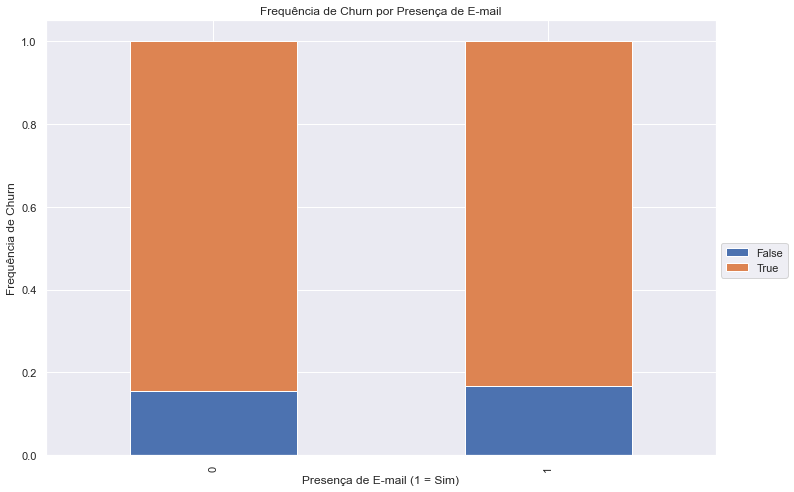

In [20]:
gg_t_email = pd.crosstab(gg_ada['email'],gg_ada['churn'])
gg_t_email.div(gg_t_email.sum(1).astype(float), axis=0).plot(figsize=(12, 8), kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Frequência de Churn por Presença de E-mail')
plt.xlabel('Presença de E-mail (1 = Sim)')
plt.ylabel('Frequência de Churn')
plt.savefig('../Imagens/churn_email_bar')

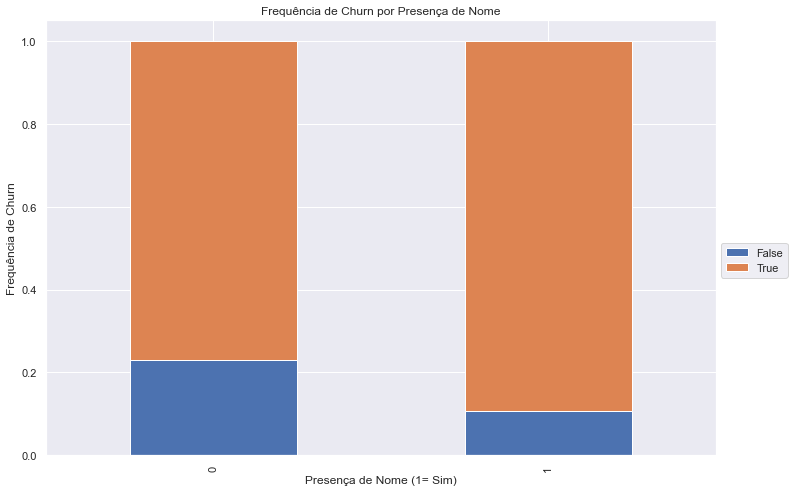

In [93]:
gg_t_name = pd.crosstab(gg_ada['name'],gg_ada['churn'])
gg_t_name.div(gg_t_name.sum(1).astype(float), axis=0).plot(figsize=(12, 8), kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Frequência de Churn por Presença de Nome')
plt.xlabel('Presença de Nome (1= Sim)')
plt.ylabel('Frequência de Churn')
plt.savefig('../Imagens/churn_nome_bar')

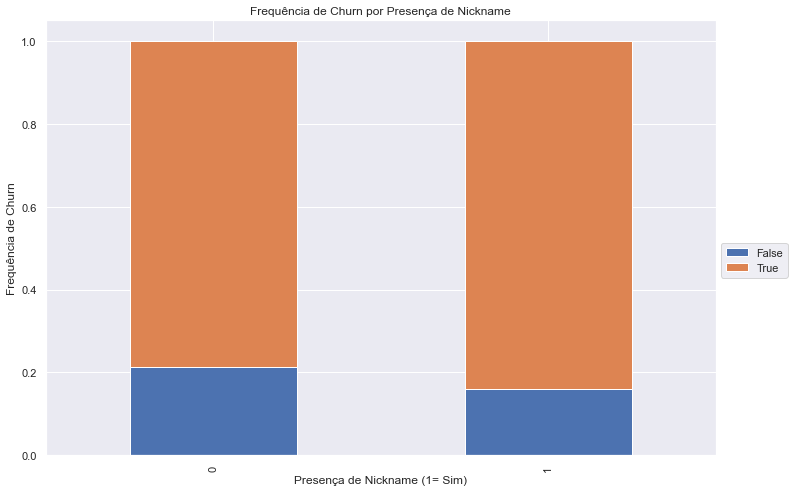

In [22]:
gg_t_nick = pd.crosstab(gg_ada['nickname'],gg_ada['churn'])
gg_t_nick.div(gg_t_nick.sum(1).astype(float), axis=0).plot(figsize=(12, 8), kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Frequência de Churn por Presença de Nickname')
plt.xlabel('Presença de Nickname (1= Sim)')
plt.ylabel('Frequência de Churn')
plt.savefig('../Imagens/churn_nick_bar')

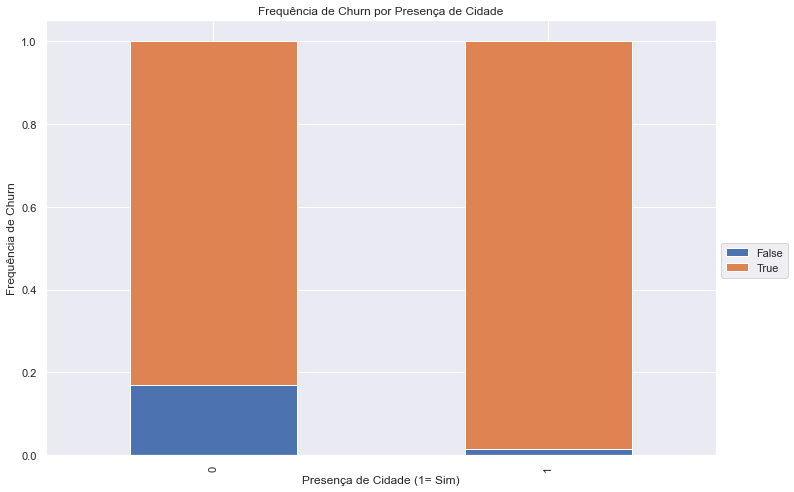

In [23]:
gg_t_city = pd.crosstab(gg_ada['city'],gg_ada['churn'])
gg_t_city.div(gg_t_city.sum(1).astype(float), axis=0).plot(figsize=(12, 8), kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Frequência de Churn por Presença de Cidade')
plt.xlabel('Presença de Cidade (1= Sim)')
plt.ylabel('Frequência de Churn')
plt.savefig('../Imagens/churn_city_bar')

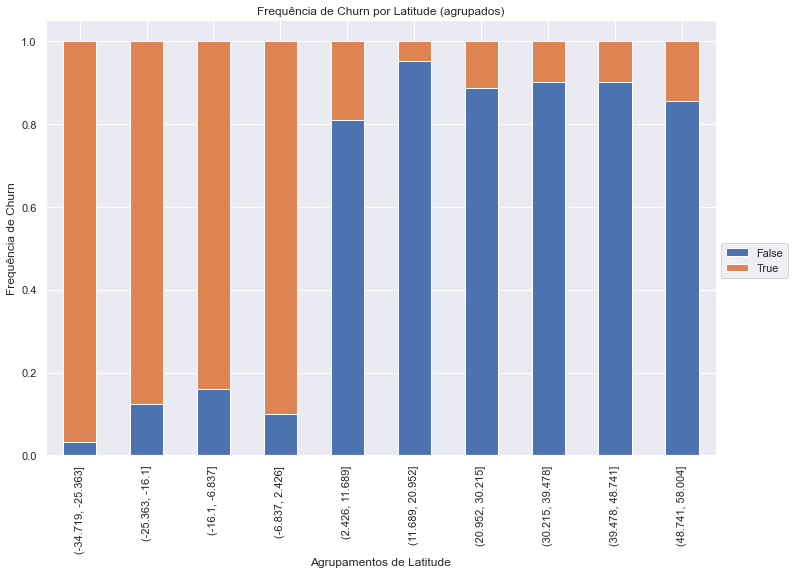

In [24]:
gg_t_lat = gg_ada.copy()
gg_t_lat['bin']=pd.cut(gg_t_lat.lat,bins=10)
table_lat = pd.crosstab(gg_t_lat['bin'],gg_t_lat['churn'])
table_lat.div(table_lat.sum(1).astype(float), axis=0).plot(figsize=(12, 8), kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Frequência de Churn por Latitude (agrupados)')
plt.xlabel('Agrupamentos de Latitude')
plt.ylabel('Frequência de Churn')
plt.savefig('../Imagens/churn_lat_bar')

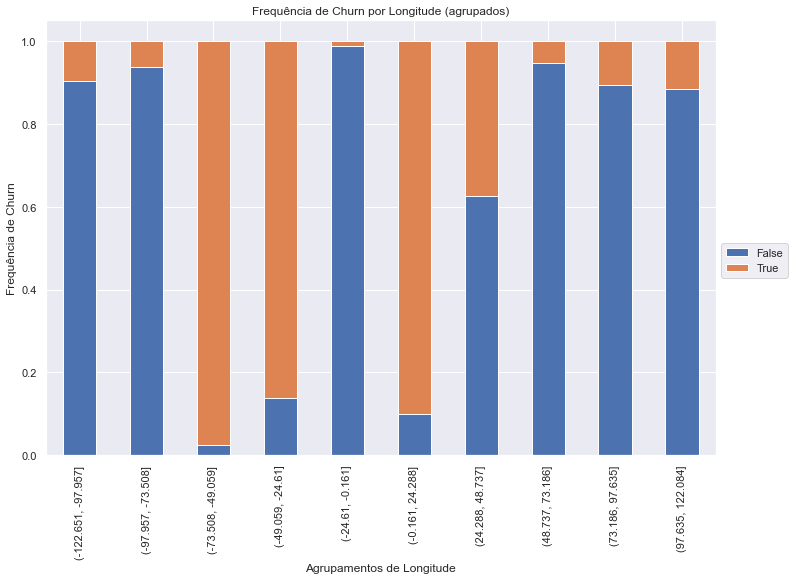

In [25]:
gg_t_lng = gg_ada.copy()
gg_t_lng['bin']=pd.cut(gg_t_lng.lng,bins=10)
table_lng = pd.crosstab(gg_t_lng['bin'],gg_t_lng['churn'])
table_lng.div(table_lng.sum(1).astype(float), axis=0).plot(figsize=(12, 8), kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Frequência de Churn por Longitude (agrupados)')
plt.xlabel('Agrupamentos de Longitude')
plt.ylabel('Frequência de Churn')
plt.savefig('../Imagens/churn_lng_bar')

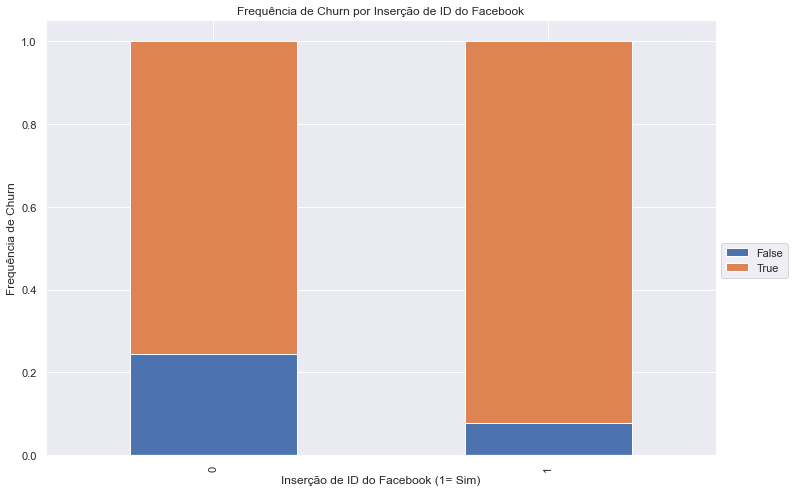

In [26]:
gg_t_fbid = pd.crosstab(gg_ada['fbid'],gg_ada['churn'])
gg_t_fbid.div(gg_t_fbid.sum(1).astype(float), axis=0).plot(figsize=(12, 8), kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Frequência de Churn por Inserção de ID do Facebook')
plt.xlabel('Inserção de ID do Facebook (1= Sim)')
plt.ylabel('Frequência de Churn')
plt.savefig('../Imagens/churn_fbid_bar')

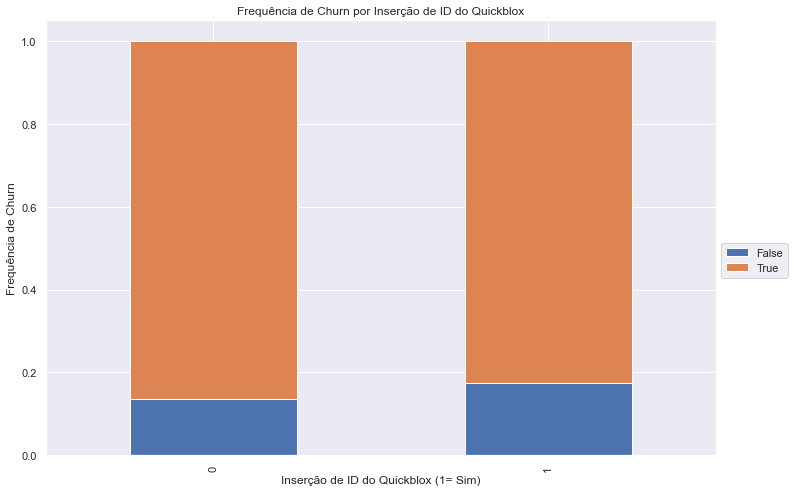

In [27]:
gg_t_quick = pd.crosstab(gg_ada['quickblox_id'],gg_ada['churn'])
gg_t_quick.div(gg_t_quick.sum(1).astype(float), axis=0).plot(figsize=(12, 8), kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Frequência de Churn por Inserção de ID do Quickblox')
plt.xlabel('Inserção de ID do Quickblox (1= Sim)')
plt.ylabel('Frequência de Churn')
plt.savefig('../Imagens/churn_quick_bar')

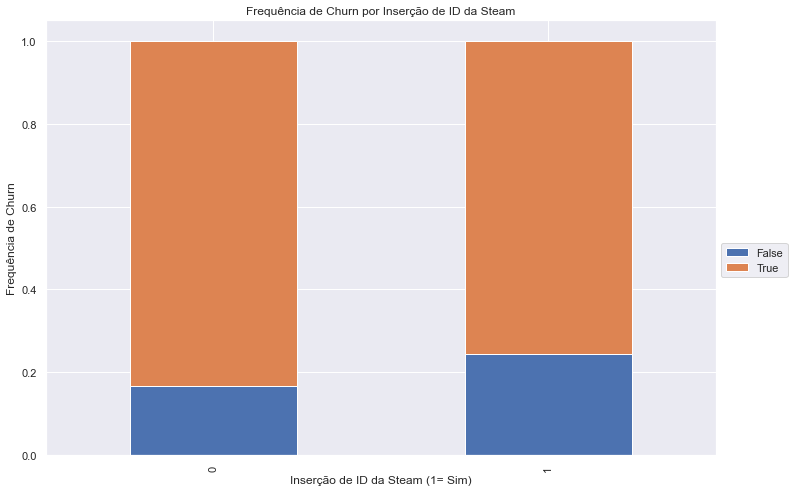

In [28]:
gg_t_steam = pd.crosstab(gg_ada['steam_id'],gg_ada['churn'])
gg_t_steam.div(gg_t_steam.sum(1).astype(float), axis=0).plot(figsize=(12, 8), kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Frequência de Churn por Inserção de ID da Steam')
plt.xlabel('Inserção de ID da Steam (1= Sim)')
plt.ylabel('Frequência de Churn')
plt.savefig('../Imagens/churn_steam_bar')

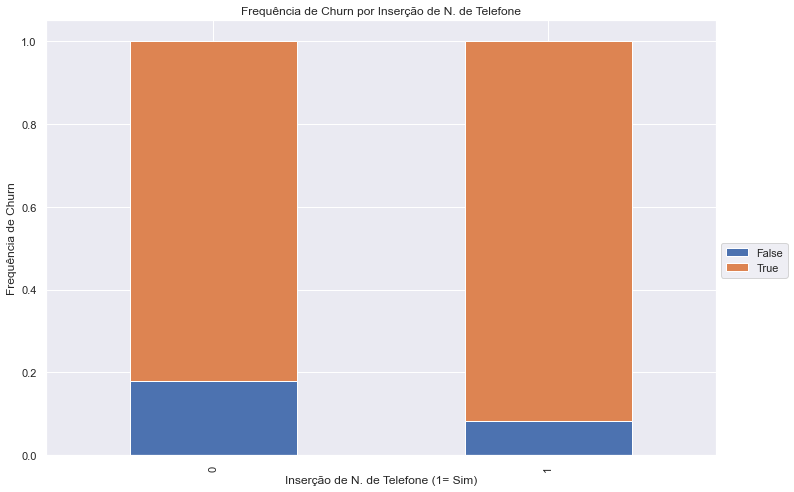

In [29]:
gg_t_phone = pd.crosstab(gg_ada['phone_number'],gg_ada['churn'])
gg_t_phone.div(gg_t_phone.sum(1).astype(float), axis=0).plot(figsize=(12, 8), kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Frequência de Churn por Inserção de N. de Telefone')
plt.xlabel('Inserção de N. de Telefone (1= Sim)')
plt.ylabel('Frequência de Churn')
plt.savefig('../Imagens/churn_phone_bar')

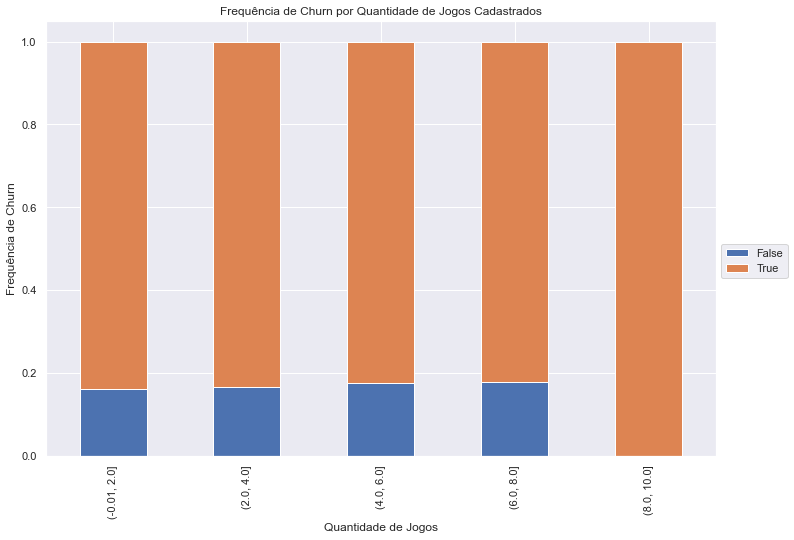

In [30]:
gg_t_games = gg_ada.loc[gg_ada['qtde_games'] <= 10]
gg_t_games['bin']=pd.cut(gg_t_games.qtde_games,bins=5)
table_games = pd.crosstab(gg_t_games['bin'],gg_t_games['churn'])
table_games.div(table_games.sum(1).astype(float), axis=0).plot(figsize=(12, 8), kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Frequência de Churn por Quantidade de Jogos Cadastrados')
plt.xlabel('Quantidade de Jogos')
plt.ylabel('Frequência de Churn')
plt.savefig('../Imagens/churn_games_bar')

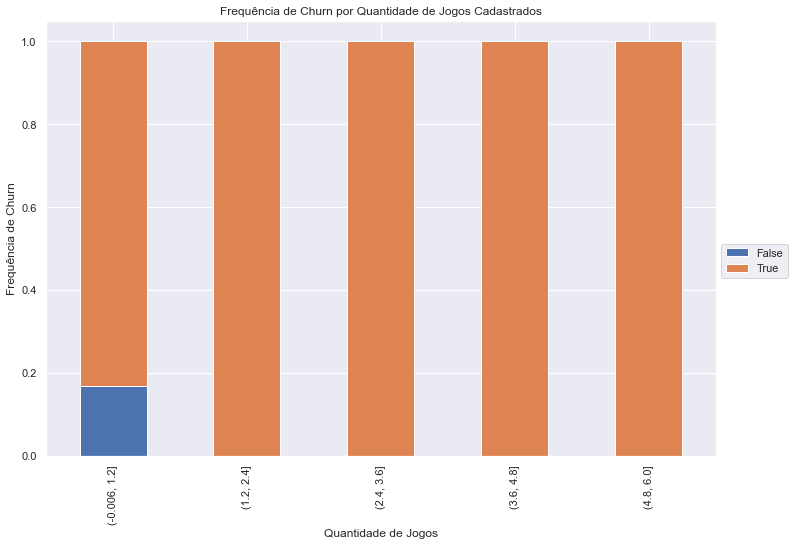

In [31]:
gg_t_grupos = gg_ada.loc[gg_ada['qtde_grupos'] <= 10]
gg_t_grupos['bin']=pd.cut(gg_t_grupos.qtde_grupos,bins=5)
table_grupos = pd.crosstab(gg_t_grupos['bin'],gg_t_grupos['churn'])
table_grupos.div(table_grupos.sum(1).astype(float), axis=0).plot(figsize=(12, 8), kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Frequência de Churn por Quantidade de Jogos Cadastrados')
plt.xlabel('Quantidade de Jogos')
plt.ylabel('Frequência de Churn')
plt.savefig('../Imagens/churn_grupos_bar')

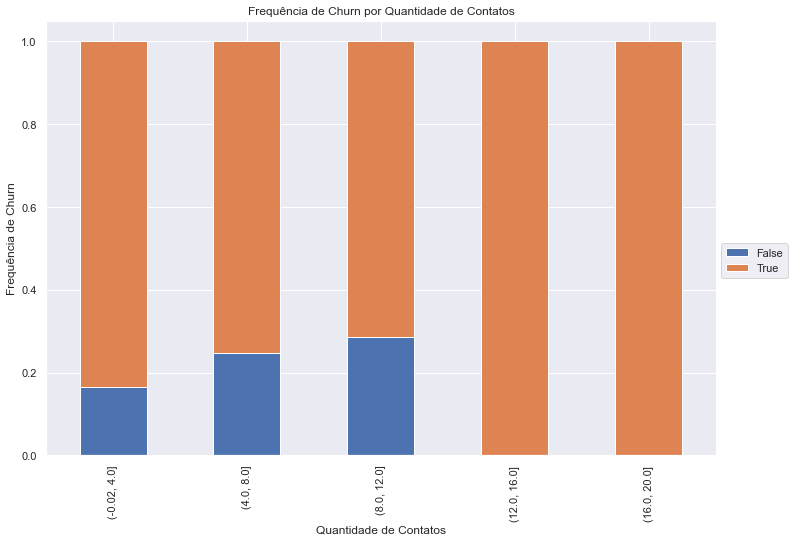

In [32]:
gg_t_contatos = gg_ada.loc[gg_ada['qtde_contatos'] <= 20]
gg_t_contatos['bin']=pd.cut(gg_t_contatos.qtde_contatos,bins=5)
table_cont = pd.crosstab(gg_t_contatos['bin'],gg_t_contatos['churn'])
table_cont.div(table_cont.sum(1).astype(float), axis=0).plot(figsize=(12, 8), kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Frequência de Churn por Quantidade de Contatos')
plt.xlabel('Quantidade de Contatos')
plt.ylabel('Frequência de Churn')
plt.savefig('../Imagens/churn_contatos_bar')

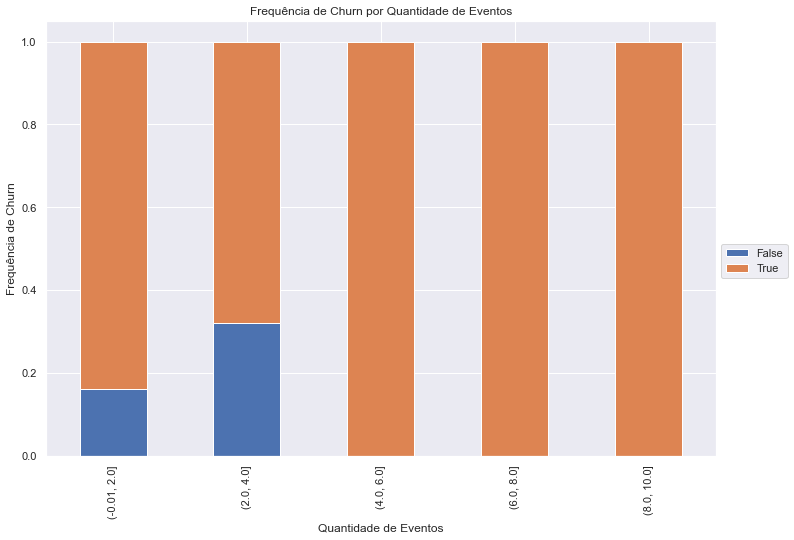

In [33]:
gg_t_eventos = gg_ada.loc[gg_ada['qtde_eventos'] <= 10]
gg_t_eventos['bin']=pd.cut(gg_t_eventos.qtde_eventos,bins=5)
table_eventos = pd.crosstab(gg_t_eventos['bin'],gg_t_eventos['churn'])
table_eventos.div(table_eventos.sum(1).astype(float), axis=0).plot(figsize=(12, 8), kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Frequência de Churn por Quantidade de Eventos')
plt.xlabel('Quantidade de Eventos')
plt.ylabel('Frequência de Churn')
plt.savefig('../Imagens/churn_events_bar')

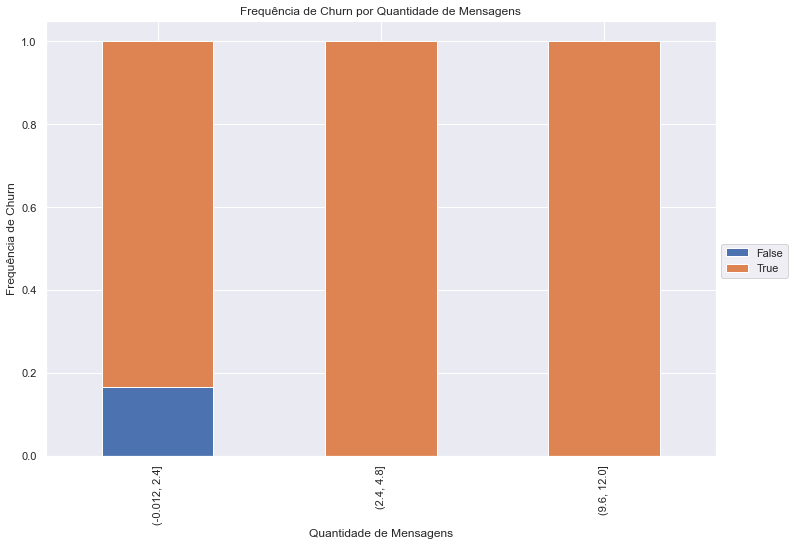

In [34]:
gg_t_mens = gg_ada.loc[gg_ada['qtde_mensagens'] <= 20]
gg_t_mens['bin']=pd.cut(gg_t_mens.qtde_mensagens,bins=5)
table_mens = pd.crosstab(gg_t_mens['bin'],gg_t_mens['churn'])
table_mens.div(table_mens.sum(1).astype(float), axis=0).plot(figsize=(12, 8), kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Frequência de Churn por Quantidade de Mensagens')
plt.xlabel('Quantidade de Mensagens')
plt.ylabel('Frequência de Churn')
plt.savefig('../Imagens/churn_mens_bar')

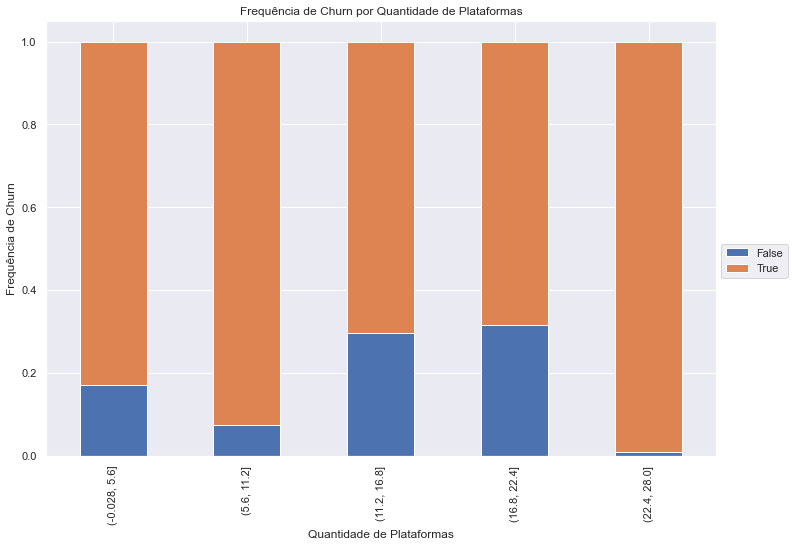

In [35]:
gg_t_plat = gg_ada.loc[gg_ada['qtde_plataformas'] <= 30]
gg_t_plat['bin']=pd.cut(gg_t_plat.qtde_plataformas,bins=5)
table_plat = pd.crosstab(gg_t_plat['bin'],gg_t_plat['churn'])
table_plat.div(table_plat.sum(1).astype(float), axis=0).plot(figsize=(12, 8), kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Frequência de Churn por Quantidade de Plataformas')
plt.xlabel('Quantidade de Plataformas')
plt.ylabel('Frequência de Churn')
plt.savefig('../Imagens/churn_plat_bar')

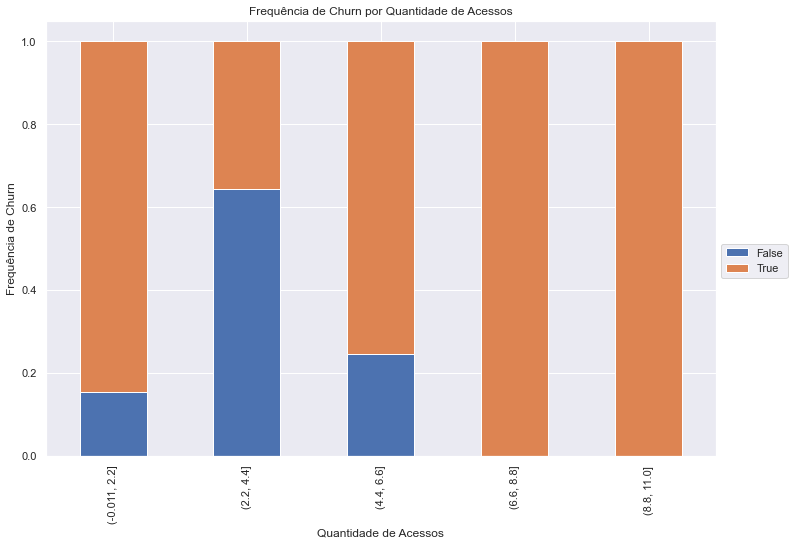

In [36]:
gg_t_acessos = gg_ada.loc[gg_ada['qtde_acessos'] <= 20]
gg_t_acessos['bin']=pd.cut(gg_t_acessos.qtde_acessos, bins=5)
table_acess = pd.crosstab(gg_t_acessos['bin'],gg_t_acessos['churn'])
table_acess.div(table_acess.sum(1).astype(float), axis=0).plot(figsize=(12, 8), kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Frequência de Churn por Quantidade de Acessos')
plt.xlabel('Quantidade de Acessos')
plt.ylabel('Frequência de Churn')
plt.savefig('../Imagens/churn_acessos_bar')

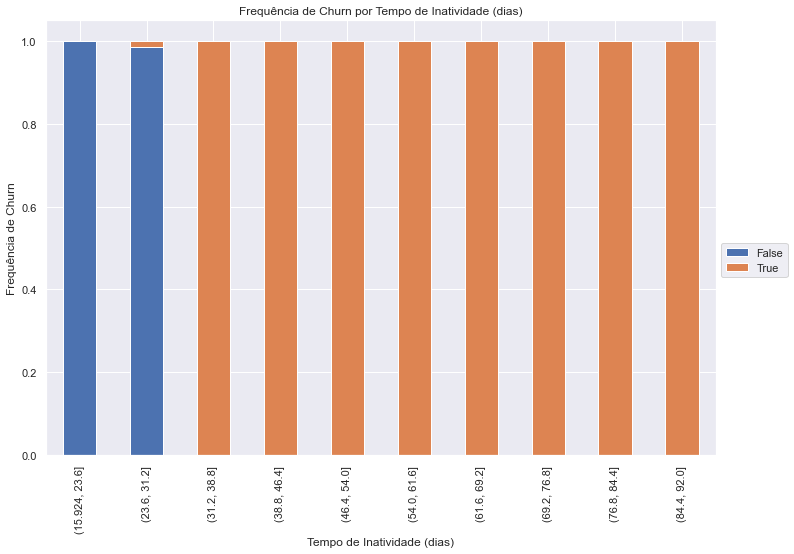

In [37]:
gg_t_inat = gg_ada.loc[gg_ada['inatividade_days'] <= 100]
gg_t_inat['bin']=pd.cut(gg_t_inat.inatividade_days, bins=10)
table_inat = pd.crosstab(gg_t_inat['bin'],gg_t_inat['churn'])
table_inat.div(table_inat.sum(1).astype(float), axis=0).plot(figsize=(12, 8), kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Frequência de Churn por Tempo de Inatividade (dias)')
plt.xlabel('Tempo de Inatividade (dias)')
plt.ylabel('Frequência de Churn')
plt.savefig('../Imagens/churn_inat_bar')

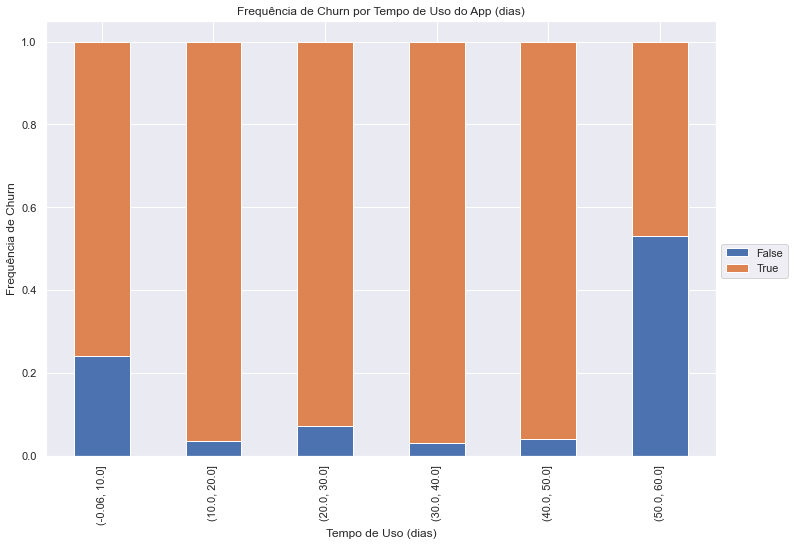

In [38]:
gg_t_uso = gg_ada.loc[gg_ada['tempo_uso_days'] <= 60]
gg_t_uso['bin']=pd.cut(gg_t_uso.tempo_uso_days, bins=6)
table_uso = pd.crosstab(gg_t_uso['bin'],gg_t_uso['churn'])
table_uso.div(table_uso.sum(1).astype(float), axis=0).plot(figsize=(12, 8), kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Frequência de Churn por Tempo de Uso do App (dias)')
plt.xlabel('Tempo de Uso (dias)')
plt.ylabel('Frequência de Churn')
plt.savefig('../Imagens/churn_uso_bar')

### Vamos eliminar mais algumas colunas que não são significativas para treinar o modelo.

In [62]:
X_ada.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16823 entries, 0 to 16822
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   email             16823 non-null  int64  
 1   name              16823 non-null  int64  
 2   nickname          16823 non-null  int64  
 3   avatar            16823 non-null  int64  
 4   profile_pic_id    16823 non-null  int64  
 5   city              16823 non-null  int64  
 6   ip_country_code   16823 non-null  int64  
 7   lat               16823 non-null  float64
 8   lng               16823 non-null  float64
 9   fbid              16823 non-null  int64  
 10  quickblox_id      16823 non-null  int64  
 11  steam_id          16823 non-null  int64  
 12  psn_id            16823 non-null  int64  
 13  xboxlive_id       16823 non-null  int64  
 14  nintendo_id       16823 non-null  int64  
 15  gamecenter_id     16823 non-null  int64  
 16  googleplay_id     16823 non-null  int64 

In [63]:
X_ada.drop(columns=['email', 
                    'inatividade_days', 
                    'pouco_uso'], inplace=True)

In [69]:
gg_test.drop(columns=['email', 
                    'inatividade_days', 
                    'pouco_uso'], inplace=True)

### Agora vamos testar alguns modelos para encontrar as melhores opções.

In [70]:
# Separando o dataset em train e test para o churn de 30 dias.
X_train, X_test, y_train, y_test = train_test_split(X_ada, y_ada, test_size=0.25, random_state=18)

In [71]:
# Vamos testar o primeiro modelo, de Regressão Logística.
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000).fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

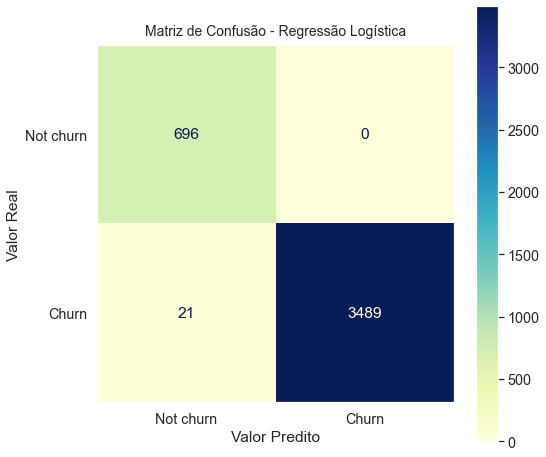

In [72]:
# Plotando a matriz de confusão.
fig, ax = plt.subplots(figsize=(8, 8))
plt.grid(False)
sns.set(font_scale=1.3)
plot_confusion_matrix(lr, X_test, y_test, cmap='YlGnBu', ax=ax)
ax.set_xlabel('Valor Predito')
ax.set_ylabel('Valor Real')
ax.set_xticklabels(['Not churn', 'Churn'])
ax.set_yticklabels(['Not churn', 'Churn'])
ax.set_title(label='Matriz de Confusão - Regressão Logística', fontsize=14, pad=10)
plt.savefig('../Imagens/confmatrix_lr')

In [73]:
print(f'Acurácia: {accuracy_score(y_test, y_pred_lr).round(4)*100}%')
print(f'Precisão: {precision_score(y_test, y_pred_lr).round(4)*100}%')
print(f'Recall:   {recall_score(y_test, y_pred_lr).round(5)*100}%')
print(f'F1-Score: {f1_score(y_true=y_test, y_pred=y_pred_lr, average="weighted").round(5)*100}%')

Acurácia: 99.5%
Precisão: 100.0%
Recall:   99.402%
F1-Score: 99.504%


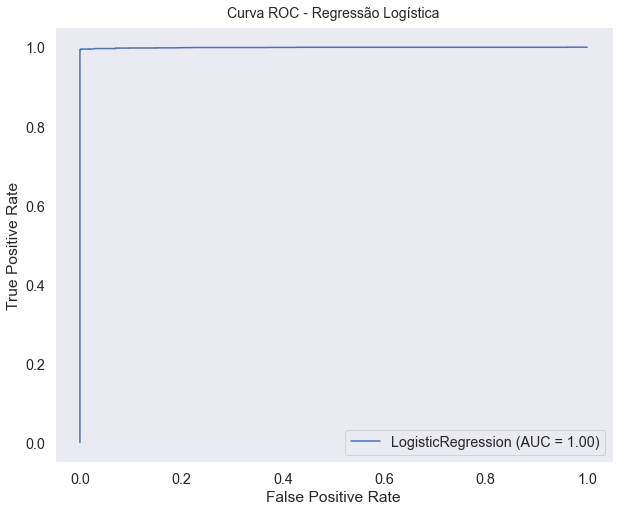

In [74]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.grid(False)
sns.set(font_scale=1.3)
plot_roc_curve(lr, X_test, y_test, ax=ax)
plt.title(label='Curva ROC - Regressão Logística', fontsize=14, pad=10)
plt.savefig('../Imagens/roc_lr')

In [75]:
svm = SVC(C=15.0, random_state=18)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

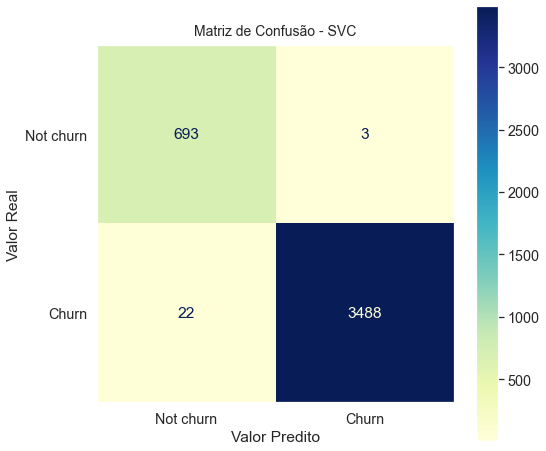

In [76]:
# Plotando a matriz de confusão.
fig, ax = plt.subplots(figsize=(8, 8))
plt.grid(False)
sns.set(font_scale=1.3)
plot_confusion_matrix(svm, X_test, y_test, cmap='YlGnBu', ax=ax)
ax.set_xlabel('Valor Predito')
ax.set_ylabel('Valor Real')
ax.set_xticklabels(['Not churn', 'Churn'])
ax.set_yticklabels(['Not churn', 'Churn'])
ax.set_title(label='Matriz de Confusão - SVC', fontsize=14, pad=10)
plt.savefig('../Imagens/confmatrix_svm')

In [77]:
print(f'Acurácia: {accuracy_score(y_test, y_pred_svm).round(4)*100}%')
print(f'Precisão: {precision_score(y_test, y_pred_svm).round(4)*100}%')
print(f'Recall:   {recall_score(y_test, y_pred_svm).round(4)*100}%')
print(f'F1-Score: {f1_score(y_true=y_test, y_pred=y_pred_svm, average="weighted").round(4)*100}%')

Acurácia: 99.41%
Precisão: 99.91%
Recall:   99.37%
F1-Score: 99.41%


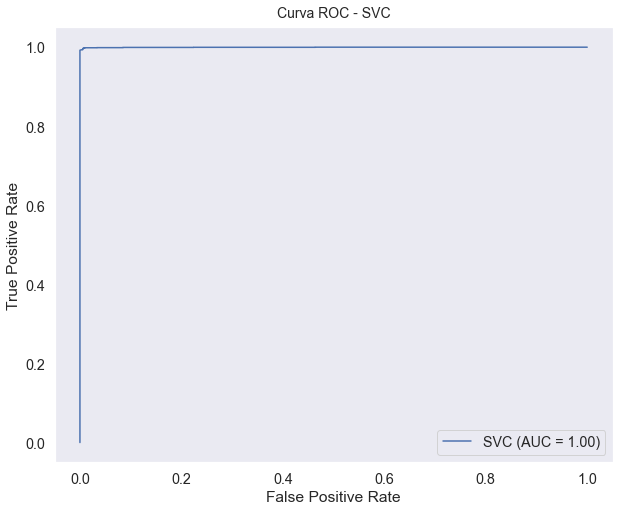

In [78]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.grid(False)
sns.set(font_scale=1.3)
plot_roc_curve(svm, X_test, y_test, ax=ax)
plt.title(label='Curva ROC - SVC', fontsize=14, pad=10)
plt.savefig('../Imagens/roc_svm')

In [79]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

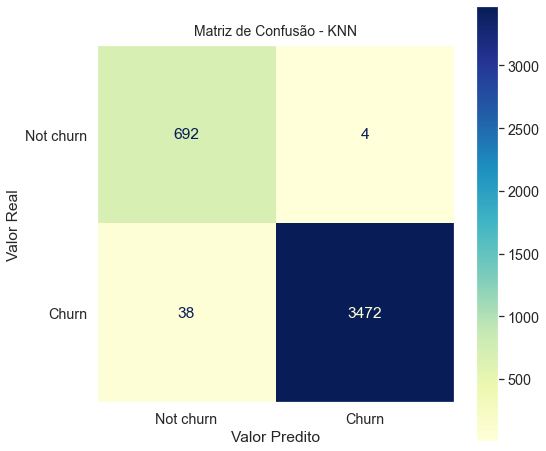

In [80]:
# Plotando a matriz de confusão.
fig, ax = plt.subplots(figsize=(8, 8))
plt.grid(False)
sns.set(font_scale=1.3)
plot_confusion_matrix(knn, X_test, y_test, cmap='YlGnBu', ax=ax)
ax.set_xlabel('Valor Predito')
ax.set_ylabel('Valor Real')
ax.set_xticklabels(['Not churn', 'Churn'])
ax.set_yticklabels(['Not churn', 'Churn'])
ax.set_title(label='Matriz de Confusão - KNN', fontsize=14, pad=10)
plt.savefig('../Imagens/confmatrix_knn')

In [81]:
print(f'Acurácia: {accuracy_score(y_test, y_pred_knn).round(5)*100}%')
print(f'Precisão: {precision_score(y_test, y_pred_knn).round(4)*100}%')
print(f'Recall:   {recall_score(y_test, y_pred_knn).round(5)*100}%')
print(f'F1-Score: {f1_score(y_true=y_test, y_pred=y_pred_knn, average="weighted").round(4)*100}%')

Acurácia: 99.00099999999999%
Precisão: 99.88%
Recall:   98.917%
F1-Score: 99.00999999999999%


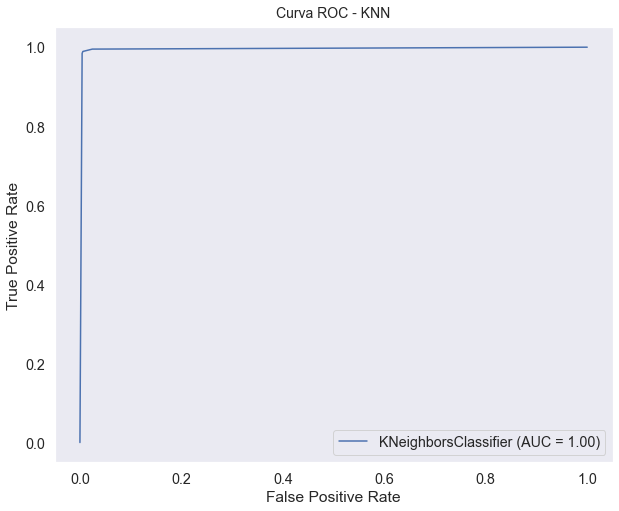

In [82]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.grid(False)
sns.set(font_scale=1.3)
plot_roc_curve(knn, X_test, y_test, ax=ax)
plt.title(label='Curva ROC - KNN', fontsize=14, pad=10)
plt.savefig('../Imagens/roc_knn')

In [83]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

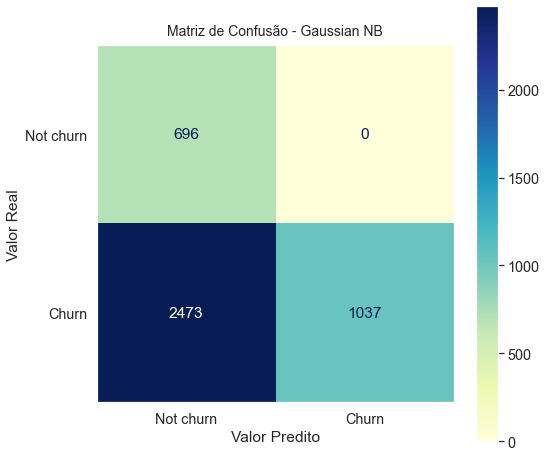

In [84]:
# Plotando a matriz de confusão.
fig, ax = plt.subplots(figsize=(8, 8))
plt.grid(False)
sns.set(font_scale=1.3)
plot_confusion_matrix(nb, X_test, y_test, cmap='YlGnBu', ax=ax)
ax.set_xlabel('Valor Predito')
ax.set_ylabel('Valor Real')
ax.set_xticklabels(['Not churn', 'Churn'])
ax.set_yticklabels(['Not churn', 'Churn'])
ax.set_title(label='Matriz de Confusão - Gaussian NB', fontsize=14, pad=10)
plt.savefig('../Imagens/confmatrix_nb')

In [85]:
print(f'Acurácia: {accuracy_score(y_test, y_pred_nb).round(5)*100}%')
print(f'Precisão: {precision_score(y_test, y_pred_nb).round(4)*100}%')
print(f'Recall:   {recall_score(y_test, y_pred_nb).round(6)*100}%')
print(f'F1-Score: {f1_score(y_true=y_test, y_pred=y_pred_nb, average="weighted").round(4)*100}%')

Acurácia: 41.203%
Precisão: 100.0%
Recall:   29.544199999999996%
F1-Score: 44.019999999999996%


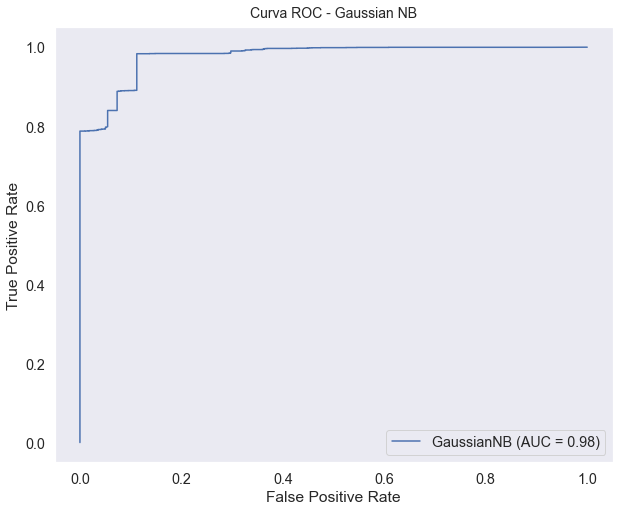

In [86]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.grid(False)
sns.set(font_scale=1.3)
plot_roc_curve(nb, X_test, y_test, ax=ax)
plt.title(label='Curva ROC - Gaussian NB', fontsize=14, pad=10)
plt.savefig('../Imagens/roc_nb')

In [87]:
dtree = DecisionTreeClassifier(max_depth=5)
dtree.fit(X_train, y_train)
y_pred_dtree = dtree.predict(X_test)

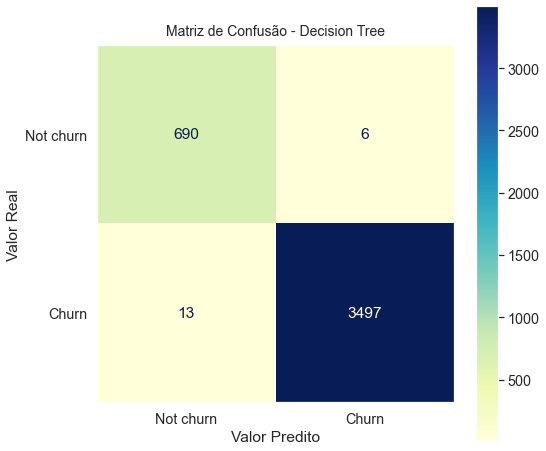

In [88]:
# Plotando a matriz de confusão.
fig, ax = plt.subplots(figsize=(8, 8))
plt.grid(False)
sns.set(font_scale=1.3)
plot_confusion_matrix(dtree, X_test, y_test, cmap='YlGnBu', ax=ax)
ax.set_xlabel('Valor Predito')
ax.set_ylabel('Valor Real')
ax.set_xticklabels(['Not churn', 'Churn'])
ax.set_yticklabels(['Not churn', 'Churn'])
ax.set_title(label='Matriz de Confusão - Decision Tree', fontsize=14, pad=10)
plt.savefig('../Imagens/confmatrix_dtree')

In [89]:
print(f'Acurácia: {accuracy_score(y_test, y_pred_dtree).round(6)*100}%')
print(f'Precisão: {precision_score(y_test, y_pred_dtree).round(4)*100}%')
print(f'Recall:   {recall_score(y_test, y_pred_dtree).round(4)*100}%')
print(f'F1-Score: {f1_score(y_true=y_test, y_pred=y_pred_dtree, average="weighted").round(3)*100}%')

Acurácia: 99.5483%
Precisão: 99.83%
Recall:   99.63%
F1-Score: 99.5%


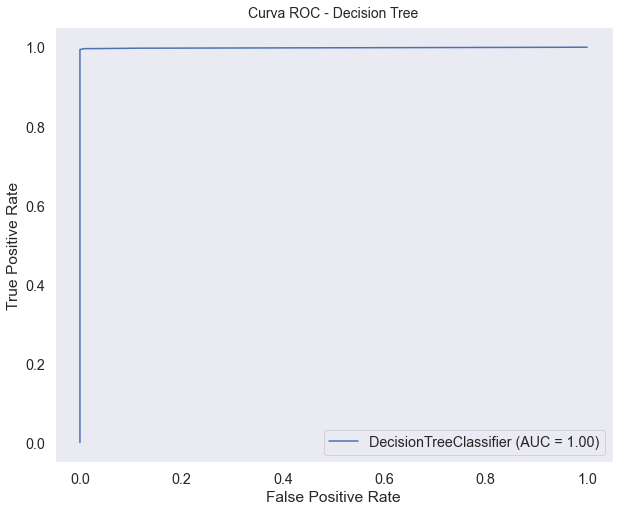

In [90]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.grid(False)
sns.set(font_scale=1.3)
plot_roc_curve(dtree, X_test, y_test, ax=ax)
plt.title(label='Curva ROC - Decision Tree', fontsize=14, pad=10)
plt.savefig('../Imagens/roc_dtree')

In [91]:
modelXG = XGBClassifier()
modelXG.fit(X_train, y_train)
y_predXG = modelXG.predict(X_test)

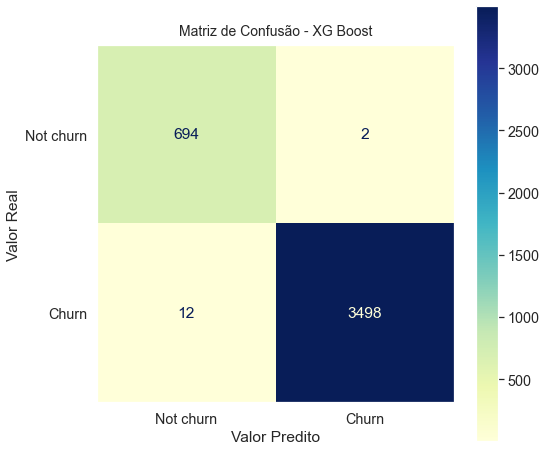

In [92]:
# Plotando a matriz de confusão.
fig, ax = plt.subplots(figsize=(8, 8))
plt.grid(False)
sns.set(font_scale=1.3)
plot_confusion_matrix(modelXG, X_test, y_test, cmap='YlGnBu', ax=ax)
ax.set_xlabel('Valor Predito')
ax.set_ylabel('Valor Real')
ax.set_xticklabels(['Not churn', 'Churn'])
ax.set_yticklabels(['Not churn', 'Churn'])
ax.set_title(label='Matriz de Confusão - XG Boost', fontsize=14, pad=10)
plt.savefig('../Imagens/confmatrix_XGB')

In [93]:
print(f'Acurácia: {accuracy_score(y_test, y_predXG).round(4)*100}%')
print(f'Precisão: {precision_score(y_test, y_predXG).round(4)*100}%')
print(f'Recall:   {recall_score(y_test, y_predXG).round(5)*100}%')
print(f'F1-Score: {f1_score(y_true=y_test, y_pred=y_predXG, average="weighted").round(4)*100}%')

Acurácia: 99.67%
Precisão: 99.94%
Recall:   99.658%
F1-Score: 99.67%


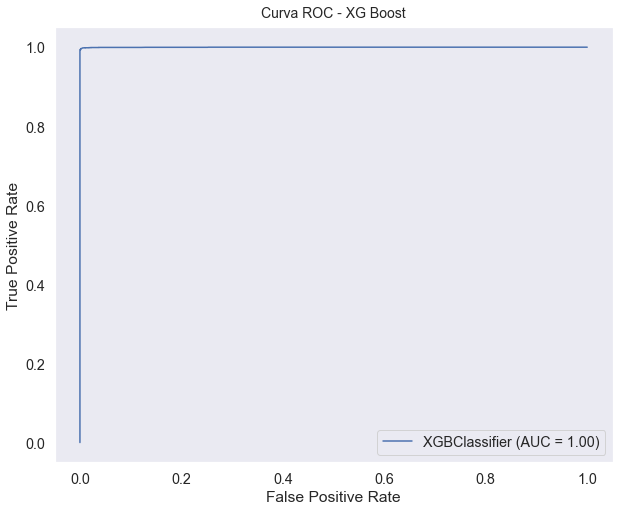

In [94]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.grid(False)
sns.set(font_scale=1.3)
plot_roc_curve(modelXG, X_test, y_test, ax=ax)
plt.title(label='Curva ROC - XG Boost', fontsize=14, pad=10)
plt.savefig('../Imagens/roc_XGB')

### Agora vamos comparar todas as curvas dos modelos para identificarmos os melhores resultados AUC.

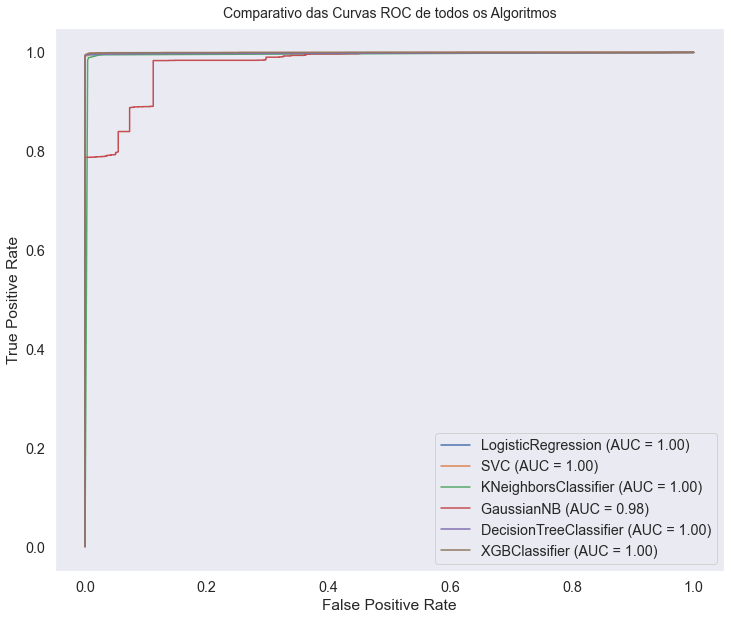

In [95]:
fig, ax = plt.subplots(figsize=(12, 10))
plt.grid(False)
sns.set(font_scale=1.3)
classifiers = [lr, svm, knn, nb, dtree, modelXG]
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=ax)

ax.set_title(label='Comparativo das Curvas ROC de todos os Algoritmos', fontsize=14, pad=10)
plt.savefig('../Imagens/roc_todos')

### Vamos montar um ensemble com os 3 melhores classificadores identificados acima.

In [96]:
# Instanciando os modelos individualmente.
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_dt = DecisionTreeClassifier(min_samples_leaf=3, min_samples_split=9, random_state=18)
clf_xgb = XGBClassifier(learning_rate=10, random_state=18)

# Definindo os estimadores selecionados.
estimators = [('knn', clf_knn), ('dtree', clf_dt), ('modelXG', clf_xgb)]

# Criando a avaliação dos classificadores e treinando o modelo.
clf_avg = VotingClassifier(estimators= estimators, voting='soft')
clf_avg.fit(X_train, y_train)

# Testando e avaliando o desempenho do modelo.
acc_avg = accuracy_score(y_test,  clf_avg.predict(X_test))
pre_avg = precision_score(y_test, clf_avg.predict(X_test))
recl_avg = recall_score(y_test, clf_avg.predict(X_test))
f1_avg = f1_score(y_true=y_test, y_pred=clf_avg.predict(X_test), average="weighted")

print('Acurácia: {:.4f}'.format(acc_avg))
print('Precisão: {:.4f}'.format(pre_avg))
print('Recall:   {:.4f}'.format(recl_avg))
print('F1-Score: {:.4f}'.format(f1_avg))

Acurácia: 0.9964
Precisão: 0.9969
Recall:   0.9989
F1-Score: 0.9964


In [97]:
estimators = [('knn', clf_knn), ('dtree', clf_dt), ('modelXG', clf_xgb)]

clf_vote = VotingClassifier(estimators=estimators)
clf_vote.fit(X_train, y_train)

clf_avg = VotingClassifier(estimators=estimators, voting='soft')
clf_avg.fit(X_train, y_train)

acc_vote = accuracy_score(y_test, clf_vote.predict(X_test))
acc_avg = accuracy_score(y_test,  clf_avg.predict(X_test))
print('Voting: {:.4f}, Averaging: {:.4f}'.format(acc_vote, acc_avg))

Voting: 0.9960, Averaging: 0.9964


### Vamos rodar o modelo com os dados desconhecidos para testar a eficácia.

In [101]:
# para igualar as bases de treino e teste, vamos separar uma amostra da 
# base desconhecida com o mesmo número de linhas da base de treino.
gg_test_2 = gg_test.sample(4207)
gg_test_2.drop(labels=68989, inplace=True) # havia uma linha com valores nulos e precisamos excluí-la.

# Listando os estimadores.
estimators = [('knn', clf_knn), ('dtree', clf_dt), ('modelXG', clf_xgb)]

# Construindo um voting classifier para avaliar os resultados.
clf_vote = VotingClassifier(estimators=estimators)
clf_vote.fit(X_train, y_train)

# Construindo um voting classifier da média para avaliar os resultados.
clf_avg = VotingClassifier(estimators=estimators, voting='hard')
clf_avg.fit(X_train, y_train)

# Avaliando o desempenho dos modelos.
acc_vote = accuracy_score(y_test, clf_vote.predict(gg_test_2))
acc_avg = accuracy_score(y_test,  clf_avg.predict(gg_test_2))
print('Voting: {:.2f}, Averaging: {:.2f}'.format(acc_vote, acc_avg))

Voting: 0.83, Averaging: 0.83


### Vamos rodar o ensemble nos dados desconhecidos e extrair a lista de potenciais churns.

In [102]:
new_churn = clf_vote.predict(gg_test_2)

In [103]:
nch = pd.Series(new_churn)

In [105]:
nch.value_counts()

True     4186
False      20
dtype: int64

In [107]:
df_pred = pd.DataFrame()

In [108]:
df_pred['user_id'] = y_test.index

In [109]:
df_pred['nch'] = nch.tolist()

In [ ]:
df_pred

In [111]:
df_not_churn = df_pred[['user_id']][df_pred['nch'] == 0]

In [112]:
df_churn = df_pred[['user_id']][df_pred['nch'] == 1]

In [ ]:
df_churn.user_id.tolist()

# Conclusão: 
### Realmente, o número de churn e potenciais churns é muito alto, indicando que serão necessárias diversas melhorias no app para que os usuários queiram ficar por mais tempo.
### Para isso, nós vamos trabalhar com a construção de algoritmos de recomendação de jogos, para melhorar a biblioteca de jogos dos usuários; e de recomendação de conexões, para sugerir conexões mais relevantes para os usuários.